# 📊 Statistical Arbitrage: BTC vs ETH

This notebook implements a basic pair trading (mean-reversion) strategy using Binance data for BTC/USDT and ETH/USDT.

This approach assumes:
- The spread between BTC and ETH (e.g., BTC − β·ETH) is assumed to revert to a long-term equilibrium.
- Hedge ratio β varies slowly.
- The residuals (spread) are assumed to be normally distributed around a mean.

## 🔧 Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import statsmodels.api as sm
from binance.client import Client
import time
from statsmodels.tsa.stattools import adfuller

## 📥 Fetch Historical Data from Binance
We will use the 6h frequency for a balance between signal granularity and execution practicality. 
We are downloading 9 months amount of BTC and ETH data.

In [2]:
client = Client(api_key='', api_secret='', tld='us')

def get_binance_data(symbol, interval, start_str, end_str=None):
    df = pd.DataFrame(client.get_historical_klines(symbol, interval, start_str, end_str))
    df = df.iloc[:, :2]
    df.columns = ['timestamp', 'close'] #['timestamp', 'open', 'high', 'low', 'close', 'volume']
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    df = df.astype(float)
    return df

btc = get_binance_data("BTCUSDT", "6h", "1 June, 2024", "1 March, 2025")['close']
eth = get_binance_data("ETHUSDT", "6h", "1 June, 2024", "1 March, 2025")['close']

df = pd.DataFrame({'btc': btc, 'eth': eth}).dropna()


## 📊 Plot Price Series

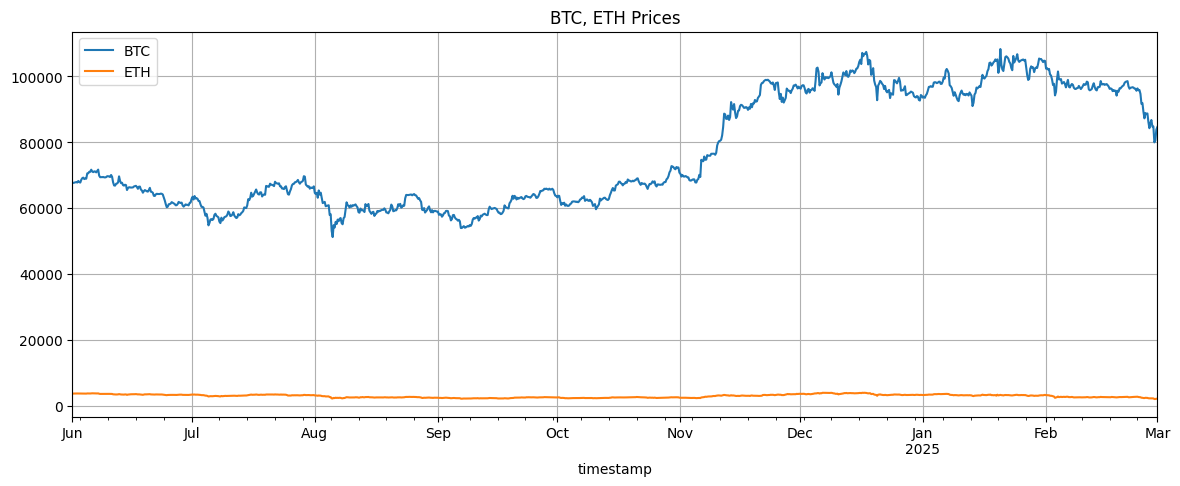

In [3]:
btc.plot(label='BTC', figsize=(14,5))
eth.plot(label='ETH')
plt.title('BTC, ETH Prices')
plt.legend()
plt.grid(True)
plt.show()

## 🔍 Construct Price Spread and Z-score

Let's calcualte rolling β and spread(BTC − β·ETH) with a given time window.

In [4]:
window = 40  # rolling window in timesteps (e.g., 40*6h ~ 10 days)
betas = []
spreads = []
btc_prices = df['btc']
eth_prices = df['eth']

# A. Calculate Dynamic Hedge Ratio (Beta) using Rolling Covariance
rolling_cov = df['btc'].rolling(window=window).cov(df['eth'])
rolling_var = df['eth'].rolling(window=window).var()
df['beta'] = rolling_cov / rolling_var

# B. Calculate the Spread
df['spread'] = df['btc'] - (df['beta'] * df['eth'])

# C. Calculate Z-Score
# CRITICAL FIX: We .shift(1) the mean/std to avoid looking into the future.
df['spread_mean'] = df['spread'].rolling(window=window).mean().shift(1)
df['spread_std'] = df['spread'].rolling(window=window).std().shift(1)
df['zscore'] = (df['spread'] - df['spread_mean']) / df['spread_std']

# Drop the initial rows where we don't have enough data for the rolling window
df.dropna(inplace=True)

# D. Cointegration Check (Safety)
adf_result = adfuller(df['spread'])
print(f"\n🔬 ADF Test P-Value: {adf_result[1]:.4f}")
if adf_result[1] > 0.05:
    print("⚠️ WARNING: The spread is NOT cointegrated (p > 0.05). Strategy may fail.")
else:
    print("✅ The spread is cointegrated. Mean reversion is statistically likely.")


🔬 ADF Test P-Value: 0.0001
✅ The spread is cointegrated. Mean reversion is statistically likely.


## 🧠 Generate Trading Signals (Mean Reversion Logic)

- The signals are long/short/exit using the Z-score range.
- Long on one unit of BTC (short on one unit of ETH) if the Z-score < -2,
- Short on one unit of BTC (long on one unit of BTC) if the Z-score > 2, 
- exit if |Z-score| < 0.5 

In [5]:
# --- 4. SIGNAL GENERATION ---
# Initialize position column
df['position'] = np.nan

ENTRY_THRESH = 2.
EXIT_THRESH = 0.5
TRADING_FEE = 0.0005
CAPITAL = 100_000

# Entry Logic
df.loc[df['zscore'] < -ENTRY_THRESH, 'position'] = 1   # Long Spread
df.loc[df['zscore'] > ENTRY_THRESH, 'position'] = -1   # Short Spread

# Exit Logic
df.loc[df['zscore'].abs() < EXIT_THRESH, 'position'] = 0

# "Hold" Logic (Forward Fill)
df['position'] = df['position'].ffill().fillna(0)

## 📉 Backtest (Simplified PnL Approximation)


📊 --- BACKTEST RESULTS ---
Initial Capital:   $100,000
Final Equity:      $114,675.31
Total Return:      14.68%
Sharpe Ratio:      1.09
Max Drawdown:      -13.93%
Total Fees Paid:   $2,833.92


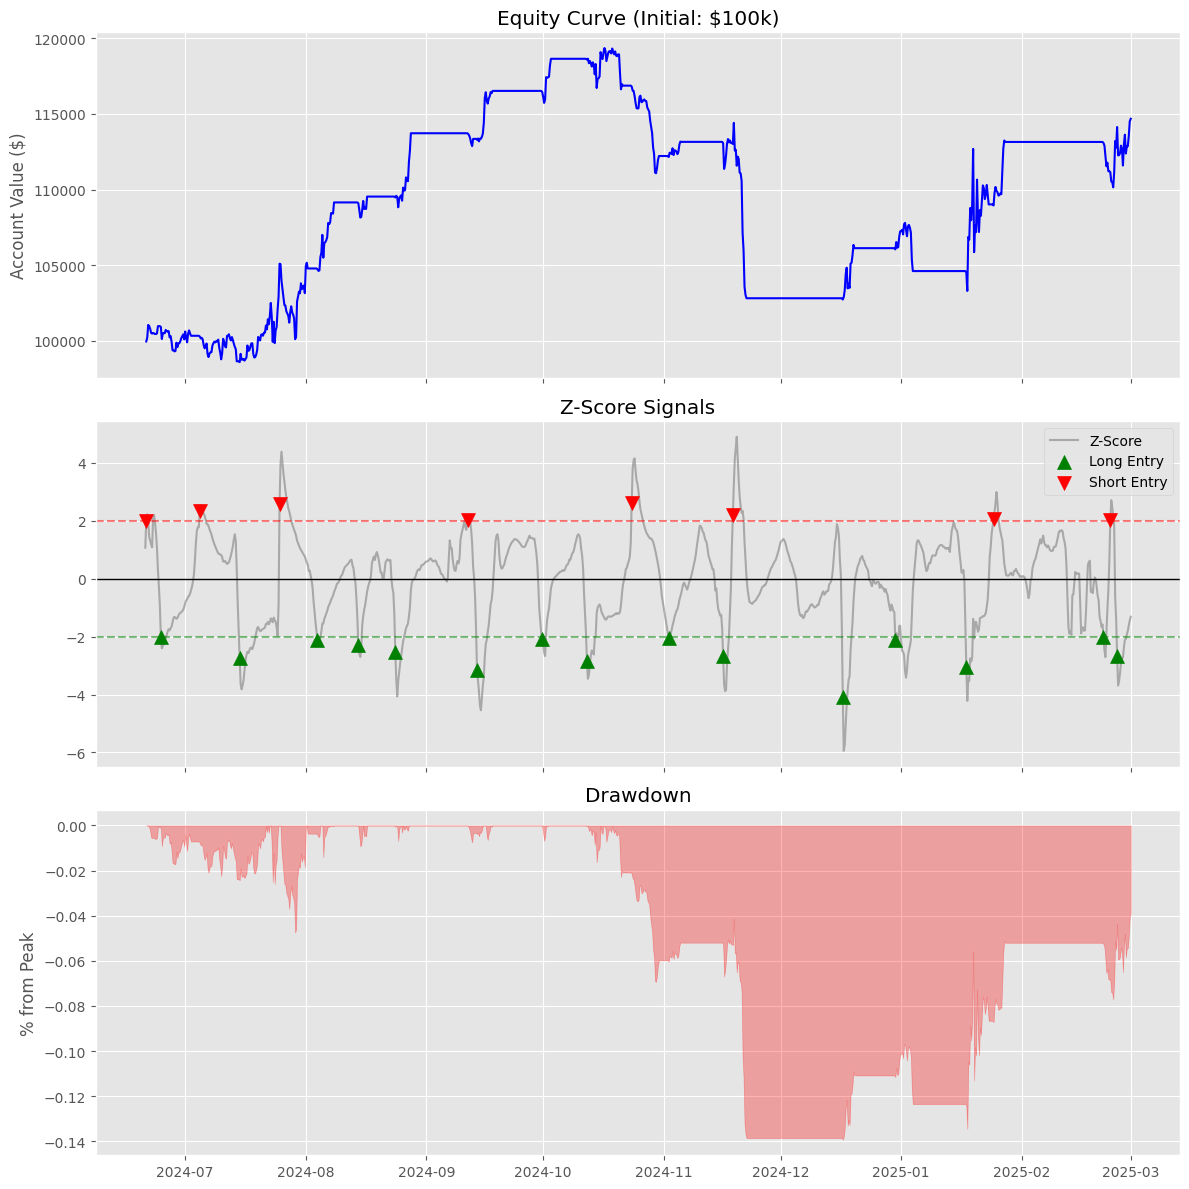

In [6]:
# --- 5. PnL CALCULATION ---
# Calculate price changes in dollars
df['change_a'] = df['btc'].diff()
df['change_b'] = df['eth'].diff()

# Gross PnL (Asset Delta Method)
# We use .shift(1) on position because we enter at the Close of T, realizing PnL on T+1
df['gross_pnl'] = df['position'].shift(1) * (
    df['change_a'] - df['beta'].shift(1) * df['change_b']
)

# Fee Calculation
# Fees are paid on turnover (entering or exiting trades)
# Notional Value ≈ Price A + (Beta * Price B)
df['turnover'] = df['position'].diff().abs().fillna(0)
df['notional'] = df['btc'] + (df['beta'] * df['eth'])
df['fees'] = df['turnover'] * df['notional'] * TRADING_FEE

# Net PnL & Equity Curve
df['net_pnl'] = df['gross_pnl'] - df['fees']
df['equity'] = CAPITAL + df['net_pnl'].cumsum()

# --- 6. PERFORMANCE STATISTICS ---
total_return = (df['equity'].iloc[-1] / CAPITAL) - 1
sharpe = (df['net_pnl'].mean() / df['net_pnl'].std()) * np.sqrt(365 * 4) # Annualized
max_dd = (df['equity'] / df['equity'].cummax() - 1).min()

print(f"\n📊 --- BACKTEST RESULTS ---")
print(f"Initial Capital:   ${CAPITAL:,.0f}")
print(f"Final Equity:      ${df['equity'].iloc[-1]:,.2f}")
print(f"Total Return:      {total_return:.2%}")
print(f"Sharpe Ratio:      {sharpe:.2f}")
print(f"Max Drawdown:      {max_dd:.2%}")
print(f"Total Fees Paid:   ${df['fees'].sum():,.2f}")

# --- 7. PLOTTING ---
plt.style.use('ggplot')
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Plot 1: Equity Curve
axes[0].plot(df.index, df['equity'], color='blue', linewidth=1.5)
axes[0].set_title(f"Equity Curve (Initial: ${CAPITAL/1000:.0f}k)")
axes[0].set_ylabel("Account Value ($)")

# Plot 2: Z-Score & Entries
axes[1].plot(df.index, df['zscore'], color='gray', alpha=0.6, label='Z-Score')
axes[1].axhline(ENTRY_THRESH, color='red', linestyle='--', alpha=0.5)
axes[1].axhline(-ENTRY_THRESH, color='green', linestyle='--', alpha=0.5)
axes[1].axhline(0, color='black', linewidth=1)

# Highlight Entry Points
longs = df[(df['position'] == 1) & (df['position'].shift(1) != 1)]
shorts = df[(df['position'] == -1) & (df['position'].shift(1) != -1)]
axes[1].scatter(longs.index, longs['zscore'], marker='^', color='green', s=100, label='Long Entry', zorder=5)
axes[1].scatter(shorts.index, shorts['zscore'], marker='v', color='red', s=100, label='Short Entry', zorder=5)
axes[1].set_title("Z-Score Signals")
axes[1].legend()

# Plot 3: Drawdown
drawdown = (df['equity'] / df['equity'].cummax() - 1)
axes[2].fill_between(drawdown.index, drawdown, 0, color='red', alpha=0.3)
axes[2].set_title("Drawdown")
axes[2].set_ylabel("% from Peak")

plt.tight_layout()
plt.show()

## 🧾 Final Remarks and Conclusion

This notebook implemented and backtested a market-neutral statistical arbitrage strategy between BTC and ETH based on dynamic hedge ratio estimation and mean-reversion in the spread.

### ✅ Key Elements:
- A **rolling OLS** model was used to estimate the dynamic hedge ratio (β), constructing the spread as - (BTC − β·ETH).
- **Z-score bands** were applied to detect deviations from the mean spread and generate long/short entry signals.
- Position exit occurred when the spread reverted close to its mean (|z| < 0.5), capturing the mean-reversion cycle.
- The strategy was backtested with a simple fee model.
- Performance metrics such as Sharpe ratio, cumulative fee, and cumulative return were used to evaluate results.]